# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
## <a href=https://www.ramp.studio/problems/el_nino>RAMP</a> on El Nino prediction

<i> Balázs Kégl (CNRS), Claire Monteleoni (GWU), Mahesh Mohan (GWU), Timothy DelSole (COLA), Kathleen Pegion (COLA), Julie Leloup (UPMC), Alex Gramfort (LTCI), Mehdi Cherti (CNRS), Camille Marini (CNRS) </i>

<h2>Introduction</h2>

A climate index is real-valued time-series which has been designated of interest in the climate literature. For example, the El Niño–Southern Oscillation (ENSO) index has widespread uses for predictions of regional and seasonal conditions, as it tends to have strong (positive or negative) correlation with a variety of weather conditions and <a href=http://www.ipcc-wg2.gov/SREX/images/uploads/SREX-SPMbrochure_FINAL.pdf>extreme events</a> throughout the globe. The ENSO index is just one of the many climate indices studied. However there is currently significant room for improvement in predicting even this extremely well studied index with such high global impact. For example, most statistical and climatological models erred significantly in their predictions of the 2015 El Niño event; their predictions were off by several months. Better tools to predict such indices are critical for seasonal and regional climate prediction, and would thus address grand challenges in the study of climate change (<a href=https://www.wcrp-climate.org/grand-challenges/grand-challenges-overview>World Climate Research Programme: Grand Challenges, 2013)</a>.

<h3>El Niño</h3>

<a href="https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php">El Niño</a> (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of $+0.5^\circ$C ($-0.5\circ$C). This standard of measure is known as the Oceanic Niño Index (ONI).

<img src="https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif">

More information can be found <a href=https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php>here</a> on why it is an important region, and what the history of the index is.

Here are the <a href = http://iri.columbia.edu/our-expertise/climate/forecasts/enso/current/>current ENSO predictions</a>, updated monthly.


<h3>The CCSM4 simulator</h3>

Our data is coming from the <a href=http://www.cesm.ucar.edu/models/ccsm4.0/>CCSM4.0</a> model (simulator). This allows us to access a full regular temperature map for a 500+ year period which makes the evaluation of the predictor more robust than if we used real measurements. 

<h3>The data</h3>

The data is a time series of "images" $z_t$, consisting of temperature measurements (for a technical reason it is not SST that we will work with, rather air temperature) on a regular grid on the Earth, indexed by lon(gitude) and lat(itude) coordinates. Latitude and longitude are sampled at a resolution of $5^\circ$, giving 37 latitude and 72 longitude grid points, 2664 temperature measurements at every time step. The average temperatures are recorded every month for 119 years, giving 1428 time points in the public training data (available in the starting kit), 155/1860 in the training data (public leaderboard), and 500/6000 in the test data (private leaderboard). The goal is to predict the average temperature in the El Niño region, <span style="color:red">6 months ahead</span>.

Note that the data set given in the starting kit is different from the one used to evaluate your submissions (of course, the data <i>structures</i> and the generative model (simulator) will be identical), so your submission should be generic (for example, it should be able to handle a time series of different length). 

<h3>The prediction task</h3>

The pipeline consists of a feature extractor and a predictor. Since the task is regression, the predictor will be a regressor, and the score (to minimize) will be the <a href=http://en.wikipedia.org/wiki/Root-mean-square_deviation>root mean square error</a>. The feature extractor will have access to the whole data. It will construct a "classical" feature matrix where each row corresponds to a time point. You should collect all information into these features that you find relevant to the regressor. The feature extractor can take <span style="color:red">anything from the past</span>, that is, it will implement a function $x_t = g(z_1, \ldots, z_t)$. Since you will have access to the full data, in theory you can cheat (even inadvertently) by using information from the future. We have implemented a randomized test to detect such submissions, but please do your best to avoid this since it would make the results irrelevant.

<h3>Domain-knowledge suggestions</h3>

You are of course free to explore any regression technique to improve the prediction. Since the input dimension is relatively large (2000+ dimensions per time point even after subsampling) sparse regression techniques (eg. LASSO) may be the best way to go, but this is just an a priori suggestion. The following list provides you other hints to start with, based on domain knowledge. 
<ul>
<li>There is a strong seasonal cycle that must be taken into account.
<li>There is little scientific/observational evidence that regions outside the Pacific play a role in NINO3.4 variability, so it is probably best to focus on Pacific SST for predictions.  
<li>The relation between tropical and extra-tropical Pacific SST is very unclear, so please explore!
<li>The NINO3.4 index has an oscillatory character (cold followed by warm followed by cold), but this pattern does not repeat exactly.  It would be useful to be able to predict periods when the oscillation is “strong” and when it “breaks down.”  
<li>A common shortcoming of empirical predictions is that they under-predict the <i>amplitude</i> of warm and cold events.  Can this be improved?
<li>There is evidence that the predictability is low when forecasts start in, or cross over, March and April (the so-called “spring barrier”). Improving predictions through the spring barrier would be important.
<ul>

# Exploratory data analysis

Packages to install:

<code>conda install xarray dask netCDF4 bottleneck basemap</code><BR>

In [2]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Let's start by reading the data into an xarray Dataset object. You can find all information on how to access and manipulate `Dataset` and `DataArray` objects at the <a href=http://xray.readthedocs.org/en/stable/>xarray site</a>.

In [3]:
X_ds = xr.open_dataset('data/train.nc')
y_array = np.load('data/train.npy')

[`xarray`](http://xarray.pydata.org/en/stable/time-series.html) uses `datetime64[ns]` as a time type which means that dates must be between 1678 and 2262. We convert whatever time type we have into `datetime64[ns]` starting at 1700. This only works if the monthly time series has length less than 562 years, which is the case of all train and test times series, both in the starting kit and in the backend. This is important so that, e.g., grouping by month works correctly.

In [9]:
X_ds['time'] = pd.date_range(
    '1/1/1700', periods=X_ds['time'].shape[0], freq='M')\
    - np.timedelta64(15, 'D')

Printing it, you can see that it contains all the data, indices, and other metadata.

In [10]:
X_ds

<xarray.Dataset>
Dimensions:  (lat: 37, lon: 72, time: 708)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...
Data variables:
    tas      (time, lat, lon) float64 246.0 246.9 245.9 246.8 246.8 246.3 ...
Attributes:
    n_burn_in:    120
    n_lookahead:  6

`y_array` on the disk is already shifted by `n_lookahead = 6` months. `n_burn_in = 120` (months) is the length of the prefix for which no prediction is required. If your feature extractor only uses these ten years of the past to extract features from, you don't need to worry about missing data in the beginning of the sequence. Otherwise you should take care of the issue "manually" (handling missing data in the beginning of the sequence).

In [12]:
y_array, y_array.shape

(array([ 299.68909098,  299.62266947,  299.38398844,  299.41364237,
         299.74432983,  300.16651611,  300.3601237 ,  300.29920146,
         300.36586202,  300.1573995 ,  300.24405314,  300.29606527,
         300.06072388,  299.21739705,  298.99423625,  299.24555969,
         299.02548319,  299.5132253 ,  299.44878337,  299.18350728,
         299.10292257,  299.31360067,  299.30114441,  299.23499146,
         298.73236389,  298.18153178,  297.7196106 ,  297.89548136,
         298.08258464,  298.2351298 ,  298.29011841,  298.43161723,
         299.01617228,  299.26343892,  299.67506612,  299.88393555,
         299.80882874,  299.32874349,  299.00979818,  299.12949015,
         299.688679  ,  299.91440837,  300.26181742,  300.25551147,
         300.16679484,  300.05690104,  300.17946676,  299.82577922,
         299.48422546,  298.83221029,  298.39238485,  298.16024679,
         298.51611837,  298.88151347,  298.73832804,  299.08477071,
         299.24384054,  299.32169291,  299.53120

The main data is in the `tas` ("temperature at surface") `DataArray`.

In [52]:
X_ds['tas']

<xarray.DataArray 'tas' (time: 708, lat: 37, lon: 72)>
[1886112 values with dtype=float64]
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5 ...
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...

You can index it in the same way as a `pandas` or `numpy` array. The result is always a `DataArray`.

In [53]:
t = 123
lat = 13
lon = 29
X_ds['tas'][t]
X_ds['tas'][t, lat]
X_ds['tas'][t, lat, lon]
X_ds['tas'][:, lat, lon]
X_ds['tas'][t, :, lon]
X_ds['tas'][:, :, lon]

<xarray.DataArray 'tas' (time: 708, lat: 37)>
array([[ 246.34985352,  253.71881104,  256.89190674, ...,  244.21122742,
         239.45343018,  237.40930176],
       [ 235.5670166 ,  243.0508728 ,  245.73396301, ...,  233.93948364,
         236.7585144 ,  236.36204529],
       [ 220.1075592 ,  228.37557983,  230.78536987, ...,  238.11174011,
         235.22380066,  234.21894836],
       ..., 
       [ 220.74520874,  225.72584534,  226.19856262, ...,  247.64707947,
         243.89697266,  242.41767883],
       [ 231.03648376,  237.40322876,  240.15187073, ...,  243.68629456,
         242.98490906,  243.19689941],
       [ 240.68638611,  247.16184998,  250.32196045, ...,  244.52952576,
         242.49557495,  240.67288208]])
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -90.0 -85.0 -80.0 -75.0 -70.0 -65.0 -60.0 -55.0 ...
    lon      float64 147.5
  * time     (time) datetime64[ns] 1700-01-16 1700-02-13 1700-03-16 ...

In [54]:
X_ds['tas'][:, lat, lon]

<xarray.DataArray 'tas' (time: 708)>
array([ 298.28366089,  297.16641235,  293.81262207,  290.67932129,
        288.5574646 ,  286.10189819,  282.77111816,  287.3918457 ,
        287.23913574,  291.52407837,  293.32342529,  298.58950806,
        297.80838013,  296.02090454,  294.62997437,  291.59881592,
        288.56741333,  286.37176514,  285.68557739,  287.47634888,
        289.69476318,  295.77468872,  297.12460327,  296.60391235,
        297.81918335,  297.8163147 ,  297.3354187 ,  293.64007568,
        289.29589844,  286.00125122,  285.09112549,  291.31518555,
        290.95117188,  293.89587402,  294.88424683,  295.25531006,
        296.10888672,  297.51812744,  295.09332275,  291.57699585,
        287.39221191,  287.14172363,  281.8807373 ,  286.84506226,
        290.7479248 ,  293.5854187 ,  295.34658813,  294.58618164,
        296.62182617,  295.3039856 ,  294.97662354,  291.61621094,
        288.56777954,  283.36322021,  282.9536438 ,  286.95681763,
        291.2963562 ,  29

You can convert any of these objects into a `numpy` array.

In [55]:
X_ds['tas'].values
X_ds['tas'][t].values
X_ds['tas'][t, lat].values
X_ds['tas'][t, lat, lon].values

array(293.3496398925781)

You can also use slices, and slice bounds don't even have to be in the index arrays. The following function computes the target at time $t$. The input is a `DataArray` (3D panel) that contains the temperatures. We select the El Niño 3.4 region and take the mean temperatures, specifying that we are taking the mean over the spatial (`lat` and `lon`) coordinates. The output is a vector with the same length as the original time series.

In [56]:
en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(dim=('lat','lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region at all time points."""
    return get_area_mean(tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)

The following function plots the temperatures at a given $t$ (time_index). 

In [57]:
el_nino_lats = [en_lat_bottom, en_lat_top, en_lat_top, en_lat_bottom]
el_nino_lons = [en_lon_right, en_lon_right, en_lon_left, en_lon_left]

from matplotlib.patches import Polygon

def plot_map(X_ds, time_index):
    def draw_screen_poly(lats, lons, m):
        x, y = m(lons, lats)
        xy = list(zip(x, y))
        poly = Polygon(xy, edgecolor='black', fill=False)
        plt.gca().add_patch(poly)

    lons, lats = np.meshgrid(X_ds['lon'], X_ds['lat'])

    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.05, 0.9,0.9])
    map = Basemap(llcrnrlon=0, llcrnrlat=-89, urcrnrlon=360, urcrnrlat=89, projection='mill')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    #map.drawcountries(linewidth=0.25)
    #map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    #map.drawmapboundary(fill_color='aqua')
    im = map.pcolormesh(
        lons, lats, X_ds[time_index] - 273.15, shading='flat', cmap=plt.cm.jet, latlon=True)
    cb = map.colorbar(im,"bottom", size="5%", pad="2%")
    draw_screen_poly(el_nino_lats, el_nino_lons, map)

    time_str = str(pd.to_datetime(str(X_ds['time'].values[time_index])))[:7]
    ax.set_title("Temperature map " + time_str)
    #plt.savefig("test_plot.pdf")
    plt.show()

Let's plot the temperature at a given time point. Feel free to change the time, play with the season, discover visually the variability of the temperature map. 

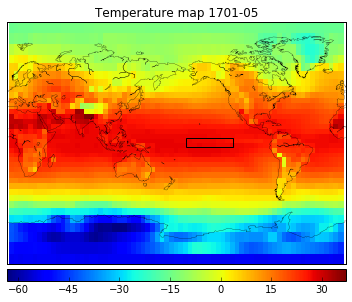

In [58]:
t = 16
plot_map(X_ds['tas'], t)

## The target

The goal is to predict the temperature in the El Niño region, $\ell = 6$ months ahead

\begin{equation}
  y_t = \frac{1}{D} \sum_{(lat, lon) \in \cal{A}_{\rm{El\ Niño}}} z_{t + \ell}^{(lat, lon)}
\end{equation}

Where $\cal{A}_{\rm{El\ Niño}} = \{(lat, lon) : -5^\circ < lat < 5^\circ \wedge -170^\circ < lon < -120^\circ\}$ is the index set of the El Niño 3.4 region, $D$ is the number of temperature measurements in the region, and $z_t^{(lat, lon)}$ is the temperature measured at time $t$, longitude $lon$ and latitude $lat$. 

The first order variation of the temperature comes from its regular yearly fluctuation. Climate scientists usually look at the temperture <i>anomaly</i>, not the raw temperature itself. More precisely, they subtract the monthly average from the temperature. We set up the RAMP to predict the raw temperature because 1) subtracting the monthly average is equivalent to adding the monthly average as an input feature to the regressor 2) we wanted to avoid computing the average on the full data since it would have violated causality (remember: you are not allowed to use the future, not even for computing averages). Nevertheless, it is interesting to look at the anomaly since you can compare it to plots produced by climate scientists.

The snippet also shows some powerful features of `xarray` (grouping by months, taking the groupby mean).

In [59]:
enso = get_enso_mean(X_ds['tas'])
enso_anomaly = enso.groupby('time.month') - enso.groupby('time.month').mean(dim='time')

We plot the anomaly in a fifty year period. Conventionally, the El Niño/La Niña threshold is $0.5^\circ$ Celsius. The plot displays the warm periods as red (El Niño) and cold perids (La Niña) as blue. To be precise, El Niño requires a period of three consecutive months with mean temperatures $0.5^\circ$ Celsius above the seasonal average, so not all colored periods qualify.

In [60]:
y.shape

(600,)

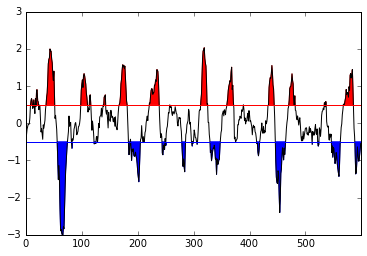

In [61]:
plt.clf()
xrange = np.arange(0, 600)
y = enso_anomaly[100:700]
x_limits = [min(xrange), max(xrange)]
y_limits = [-3.0, 3.0]
el_nino_threshold = 0.5
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.plot(xrange, y, c='black')
plt.plot(x_limits, [el_nino_threshold, el_nino_threshold], c='r')
plt.plot(x_limits, [-el_nino_threshold, -el_nino_threshold], c='b')
plt.fill_between(xrange, el_nino_threshold, y, color='red', where=y>=el_nino_threshold, interpolate=True)
plt.fill_between(xrange, -el_nino_threshold, y, color='blue', where=y<=-el_nino_threshold)
# plt.savefig("anomaly.png")

## The cross-validation object

Cross validating time-series predictors is tricky. We can't simply shuffle the observations $z_t =$ <code>X_ds['tas'][t]</code> since we would lose both causality and the correlation structure that follows natural order. 

To formalize the issue, let us first define formally the predictor that we will produce in the RAMP. Let the time series be $z_1, \ldots, z_T$ and the let target to predict at time $t$ be $y_t$. The target is usually (and in our case) a function of the future $z_{t+1}, \ldots$, but it can be anything else. We want to learn a function that predicts $y$ from the past, that is

\begin{equation}
\hat{y}_t = f(z_1, ..., z_t) = f(Z_t)
\end{equation}

where $Z_t = (z_1, ..., z_t)$ is the past. Now, the sample $(Z_t, y_t)$ is a regular (although none iid) sample from the point of view of shuffling, so we can train on $\{Z_t, y_t\}_{t \in \cal{I}_{\text{train}}}$ and test on $(Z_t, y_t)_{t \in \cal{I}_{\text{test}}}$, where $\cal{I}_{\text{train}}$ and $\cal{I}_{\text{test}}$ are arbitrary but disjunct train and test index sets, respectively (typically produced by sklearn's `ShuffleSplit`). Using shuffling would nevertheless allow a second order leakage from training points to test points that preceed them, by, e.g., aggregating the training set and adding the aggregate back as a feature. To avoid this, we use block-CV: on each fold, all $t \in \cal{I}_{\text{test}}$ are larger than all $t \in \cal{I}_{\text{train}}$. We also make sure that all training and test sets contain consecutive observations, so recurrent nets and similar predictors, which rely on this, may be trained.

The training algorithm thus maps $(Z_t, y_t)_{t \in \cal{I}_{\text{train}}}$ to $f$. The point $Z_t$ contains the target for all training points $Z_{t'}$ for $t' \le t - 6$, so it is technically possible to cheat: when you receive a test set $z_1, ..., z_T$, you could look up the target of $z_t$ in $z_{t+6}$. To detect this (often inadvertant) cheating, we will check that you feature extractor is invariant to the future. 

To allow a reasonably long past before making the first prediction, we strip the first $b = 120$ months (burn-in). You can of course use a longer window in your feature extractor, but in this case you will have to handle the missing time points in the beginning of the sequence.

## The pipeline

We have factorized the pipeline into two steps. The first feature extractor $g$ transforms the past into a classical feature vector $x_t = g(Z_t)$, and the classical regressor $h$ predicts the target from the feature vector $\hat{y}_t = h(x_t)$. To summarize, the full predictor is a composition $f(Z_t) = h(g(Z_t))$. If you have a complex solution where this factorization does not make sense (e.g., RNNs), you can do all the work in the (optional) fit function of the feature extractor, send the prediction as a single feature $x_t$ to the regressor, and simply use an identity function in the regressor $\hat{y}_t = x_t$.

### The feature extractor

The feature extractor implements a single `transform` function. As we explained above, it receives the full `X_ds` including the burn-in period $b$ as an attribute. <font color='red'>It should produce a feature matrix of length $T - b$</font>, of type numpy array, representing the past vector $(Z_{t+b}, \ldots, Z_{T})$. For constructing/computing $x_t$, it can only use the past $Z_t = (z_1, \ldots, z_t) = $ `X_ds['tas'][:t]`.

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [24]:
%%file submissions/starting_kit/ts_feature_extractor.py
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(
        dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region.

    At all time point.
    """
    return get_area_mean(
        tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino mean at time t - (12 - X_ds.n_lookahead).

        Corresponding the month to be predicted.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        enso = get_enso_mean(X_ds['tas'])
        # Roll the input series back so it corresponds to the month to be
        # predicted
        enso_rolled = np.roll(enso, 12 - X_ds.n_lookahead)
        # Strip burn in.
        enso_valid = enso_rolled[valid_range]
        # Reshape into a matrix of one column
        X_array = enso_valid.reshape((-1, 1))
        return X_array



Overwriting submissions/starting_kit/ts_feature_extractor.py


### The regressor

The regressor should implement a scikit-klearn-like regressor with fit and predict functions. The starting kit uses a linear model.

In [13]:
%%file submissions/starting_kit/regressor.py
from sklearn.base import BaseEstimator
from sklearn import linear_model


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = linear_model.BayesianRidge()

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)



Overwriting submissions/starting_kit/regressor.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `ts_feature_extractor.py` and  `regressor.py` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.nc` and `test.nc` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [14]:
!ramp_test_submission

Testing El Nino forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 300 months = 25 years
length of validation block: 288 months = 24 years
length of each cv block: 36 months = 3 years
Training ./submissions/starting_kit ...
CV fold 0
	train rmse = 0.952
	valid rmse = 0.79
	test rmse = 0.774
CV fold 1
	train rmse = 0.94
	valid rmse = 0.778
	test rmse = 0.775
CV fold 2
	train rmse = 0.917
	valid rmse = 0.799
	test rmse = 0.774
CV fold 3
	train rmse = 0.887
	valid rmse = 0.842
	test rmse = 0.774
CV fold 4
	train rmse = 0.92
	valid rmse = 0.714
	test rmse = 0.776
CV fold 5
	train rmse = 0.902
	valid rmse = 0.746
	test rmse = 0.776
CV fold 6
	train rmse = 0.877
	valid rmse = 0.854
	test rmse = 0.775
CV fold 7
	train rmse = 0.875
	valid rmse = 0.844
	test rmse = 0.776
----------------------------
train rmse = 0.909 ± 0.0267
valid rmse = 0.796 ± 0.0466
test rmse = 0.775 ± 0.0009
----------------------------
Testing if the notebook can be converted to 

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [21]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [ ]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [el nino](https://www.ramp.studio/events/el_nino) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/el_nino/sandbox) and copy-paste (or upload) [`ts_feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/ts_feature_extractor.py) and [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/el_nino/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/el_nino/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/el_nino/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.909 ± 0.0267
valid rmse = 0.796 ± 0.0466
test rmse = 0.775 ± 0.0009
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/el_nino/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.796 ± 0.0466`. When the score is good enough, you can submit it at the RAMP.

## Other models in the starting kit

To get you started, we made several other example submissions.

This one uses the whole temperature field at time $t$ as the feature vector.

In [27]:
%%file submissions/whole_field/ts_feature_extractor.py
import numpy as np


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the whole field at time t."""
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        # Take the whole temperature field.
        all = X_ds['tas'].values
        # Vectorize it to obtain a single feature vector at time t.
        vectorized = all.reshape(len(all), -1)
        # Strip burn-in.
        X_array = vectorized[valid_range]
        return X_array



Overwriting submissions/whole_field/ts_feature_extractor.py


You can test this by

In [26]:
!ramp_test_submission --submission whole_field

Testing El Nino forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 300 months = 25 years
length of validation block: 288 months = 24 years
length of each cv block: 36 months = 3 years
Training ./submissions/whole_field ...
CV fold 0
	train rmse = 0.199
	valid rmse = 0.629
	test rmse = 0.624
CV fold 1
	train rmse = 0.213
	valid rmse = 0.63
	test rmse = 0.586
CV fold 2
	train rmse = 0.227
	valid rmse = 0.608
	test rmse = 0.553
CV fold 3
	train rmse = 0.224
	valid rmse = 0.624
	test rmse = 0.534
CV fold 4
	train rmse = 0.249
	valid rmse = 0.578
	test rmse = 0.542
CV fold 5
	train rmse = 0.165
	valid rmse = 0.649
	test rmse = 0.638
CV fold 6
	train rmse = 0.237
	valid rmse = 0.592
	test rmse = 0.542
CV fold 7
	train rmse = 0.243
	valid rmse = 0.705
	test rmse = 0.533
----------------------------
train rmse = 0.22 ± 0.0256
valid rmse = 0.627 ± 0.0363
test rmse = 0.569 ± 0.0393
----------------------------
Testing if the notebook can be converted to 

This one computes two features: the anomaly with respect to the seasonal average corresponding to the current monthand the seasonal average corresponding to the month to be predicted.

In [68]:
%%file submissions/seasonal_anomalies/ts_feature_extractor.py
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(
        dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region.

    At all time point.
    """
    return get_area_mean(
        tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Anomaly and running mean.

        Compute the El Nino running mean at time t - (12 - X_ds.n_lookahead),
        corresponding the month to be predicted and the anomaly at time t
        (the difference between the temperature and the monthly running mean).

        The code is short but inefficient.
        """
        n_lookahead = X_ds.n_lookahead
        n_burn_in = X_ds.n_burn_in
        enso = get_enso_mean(X_ds['tas'])
        # The running monthly mean at time t (for every month).
        # It is using xarray's groupby at every t,
        # so its running time is O(T^2). In principle it can be computed in
        # O(T).
        running_monthly_means = np.array([
            enso.isel(time=slice(None, t)).groupby('time.month').mean(
                dim='time')
            for t in range(X_ds.n_burn_in, len(X_ds['tas']))])
        # The running monthly mean at time t
        # (corresponding to the current month).
        running_monthly_means_t0 = np.array(
            [running_monthly_means[t, t % 12]
             for t in range(len(running_monthly_means))])
        # The running monthly mean at time t
        # (corresponding to the month to be predicted).
        running_monthly_means_lookahead = np.array(
            [running_monthly_means[t, (t + n_lookahead) % 12]
             for t in range(len(running_monthly_means))])
        # The temperature anomaly at t0
        anomalys = enso.values[n_burn_in:] - running_monthly_means_t0
        X_array = np.array([running_monthly_means_lookahead, anomalys]).T
        return X_array


Overwriting submissions/seasonal_anomalies/ts_feature_extractor.py


You can test this by

In [65]:
!ramp_test_submission --submission seasonal_anomalies

Testing El Nino forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 300 months = 25 years
length of validation block: 288 months = 24 years
length of each cv block: 36 months = 3 years
Training ./submissions/seasonal_anomalies ...
CV fold 0
	train rmse = 0.76
	valid rmse = 0.653
	test rmse = 0.643
CV fold 1
	train rmse = 0.754
	valid rmse = 0.638
	test rmse = 0.638
CV fold 2
	train rmse = 0.74
	valid rmse = 0.647
	test rmse = 0.638
CV fold 3
	train rmse = 0.714
	valid rmse = 0.69
	test rmse = 0.638
CV fold 4
	train rmse = 0.744
	valid rmse = 0.575
	test rmse = 0.637
CV fold 5
	train rmse = 0.728
	valid rmse = 0.599
	test rmse = 0.637
CV fold 6
	train rmse = 0.708
	valid rmse = 0.697
	test rmse = 0.637
CV fold 7
	train rmse = 0.703
	valid rmse = 0.746
	test rmse = 0.638
----------------------------
train rmse = 0.731 ± 0.0201
valid rmse = 0.656 ± 0.0516
test rmse = 0.638 ± 0.002
----------------------------
Testing if the notebook can be converte

## The illegal lookahead check

Since the feature extractor receives the full data series which contains the target, we have no technical constraints against cheating, that is, using information coming after the present (six months before the target). We can nevertheless check wether the feature $x_t$ changes if we alter the future $(z_{t+1}, \ldots)$. The check is implemented both in the unit test (so you can check if your submission is valid) and at our backend (so you will receive a similar error message on the leaderboard if your model doesn't pass the test).

Of course, you have no reason to deliberately cheat, but it is possible that you accidentally introduce a bug. For example, the code below rolls the features in the wrong way (forward instead of backward):

```enso_rolled = np.roll(enso, -X_ds.n_lookahead)```

In [67]:
%%file submissions/illegal_lookahead/ts_feature_extractor.py
import numpy as np

en_lat_bottom = -5
en_lat_top = 5
en_lon_left = 360 - 170
en_lon_right = 360 - 120


def get_area_mean(tas, lat_bottom, lat_top, lon_left, lon_right):
    """The array of mean temperatures in a region at all time points."""
    return tas.loc[:, lat_bottom:lat_top, lon_left:lon_right].mean(
        dim=('lat', 'lon'))


def get_enso_mean(tas):
    """The array of mean temperatures in the El Nino 3.4 region.

    At all time point.
    """
    return get_area_mean(
        tas, en_lat_bottom, en_lat_top, en_lon_left, en_lon_right)


class FeatureExtractor(object):

    def __init__(self):
        pass

    def transform(self, X_ds):
        """Compute the El Nino mean at time t - (12 - X_ds.n_lookahead).

        Corresponding the month to be predicted.
        """
        # This is the range for which features should be provided. Strip
        # the burn-in from the beginning.
        valid_range = np.arange(X_ds.n_burn_in, len(X_ds['time']))
        enso = get_enso_mean(X_ds['tas'])
        # Roll the input series forward ("by accident" :)) so it uses the
        # target as input.
        enso_rolled = np.roll(enso, -X_ds.n_lookahead)
        # Strip burn in.
        enso_valid = enso_rolled[valid_range]
        # Reshape into a matrix of one column
        X_array = enso_valid.reshape((-1, 1))
        return X_array



Overwriting submissions/illegal_lookahead/ts_feature_extractor.py


Check what happens when the unit test is run.

In [66]:
!ramp_test_submission --submission illegal_lookahead

Testing El Nino forecast
Reading train and test files from ./data ...
Reading cv ...
length of common block: 300 months = 25 years
length of validation block: 288 months = 24 years
length of each cv block: 36 months = 3 years
Training ./submissions/illegal_lookahead ...
Traceback (most recent call last):
  File "/Users/kegl/anaconda/bin/ramp_test_submission", line 11, in <module>
    load_entry_point('ramp-workflow', 'console_scripts', 'ramp_test_submission')()
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/utils/command_line.py", line 51, in ramp_test_submission
    submission=sub)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/utils/testing.py", line 83, in assert_submission
    module_path, X_train, y_train, train_is=train_is)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/workflows/el_nino.py", line 32, in train_submission
    ts_fe, X_train_ds)
  File "/Users/kegl/Research/RAMP/ramp-workflow/rampwf/workflows/ts_feature_extractor.py", line 59, in test_submis

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=el nino notebook).